# **Machine learning models for energy demand forecasting**

### **Loading the dataset**

New England as used in the 2017 Global Energy Forecasting Competition (GEFCom2017) as available from Cameron Roach's repository at Github: https://github.com/camroach87/gefcom2017data

In [1]:
!pip install pyreadr

     |████████████████████████████████| 361 kB 16.1 MB/s 


In [2]:
import requests
resp = requests.get("https://github.com/camroach87/gefcom2017data/raw/master/data/gefcom.rda", allow_redirects=True)
open('gefcom.rda', 'wb').write(resp.content)

6577272

In [3]:
import pyreadr
result = pyreadr.read_r('gefcom.rda')
df = result["gefcom"]

In [4]:
df.head()

,ts,zone,demand,drybulb,dewpnt,date,year,month,hour,day_of_week,day_of_year,weekend,holiday_name,holiday,trend
0,2003-03-01 00:00:00,CT,3386.0,25.0,19.0,2003-03-01,2003.0,Mar,1.0,Sat,60.0,True,NaN,False,0.0
1,2003-03-01 01:00:00,CT,3258.0,23.0,18.0,2003-03-01,2003.0,Mar,2.0,Sat,60.0,True,NaN,False,1.0
2,2003-03-01 02:00:00,CT,3189.0,22.0,18.0,2003-03-01,2003.0,Mar,3.0,Sat,60.0,True,NaN,False,2.0
3,2003-03-01 03:00:00,CT,3157.0,22.0,19.0,2003-03-01,2003.0,Mar,4.0,Sat,60.0,True,NaN,False,3.0
4,2003-03-01 04:00:00,CT,3166.0,23.0,19.0,2003-03-01,2003.0,Mar,5.0,Sat,60.0,True,NaN,False,4.0


In [5]:
df.zone.unique()

array(['CT', 'MASS', 'ME', 'NEMASSBOST', 'NH', 'RI', 'SEMASS', 'TOTAL',
       'VT', 'WCMASS'], dtype=object)

In [6]:
df.ts.dtypes

dtype('<M8[ns]')

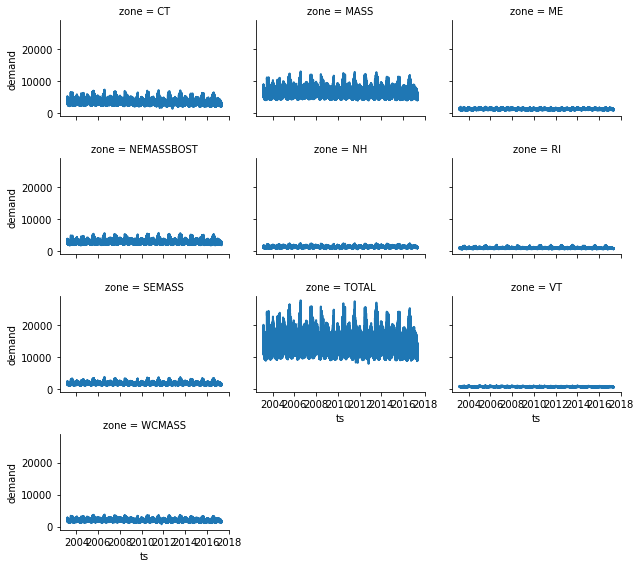

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

g = sns.relplot(
    data=df,
    x="ts", y="demand", col="zone",
    kind="line", palette="crest", linewidth=2, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=False,
)

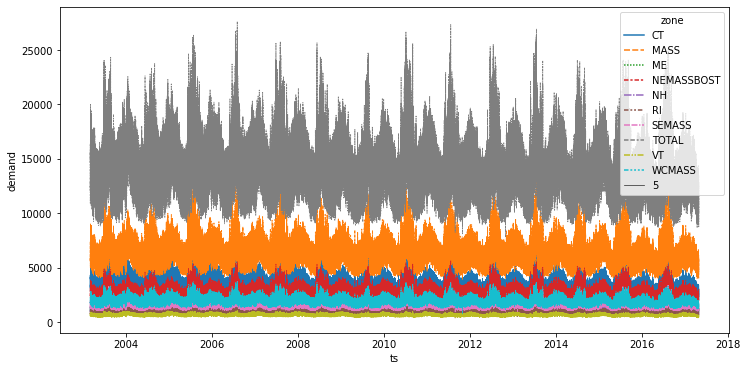

In [8]:
plt.subplots(figsize=[12, 6])
sns.lineplot(
    data=df, x="ts", y="demand", hue="zone", style="zone", size=5,
    estimator=None, color=".7", linewidth=1,
)

In [9]:
dataset = df[
             df["zone"].isin(['CT', 'ME', 'NEMASSBOST', 'NH', 'RI', 'SEMASS',
                           'VT', 'WCMASS'])
             ]
# TOTAL and MASS are aggregated differently. We won't use these two "zones".

In [10]:
dataset.columns
# The Dry Bulb, Wet Bulb and Dew Point temperatures are important to determine the state of humid air

Index(['ts', 'zone', 'demand', 'drybulb', 'dewpnt', 'date', 'year', 'month',
       'hour', 'day_of_week', 'day_of_year', 'weekend', 'holiday_name',
       'holiday', 'trend'],
      dtype='object')

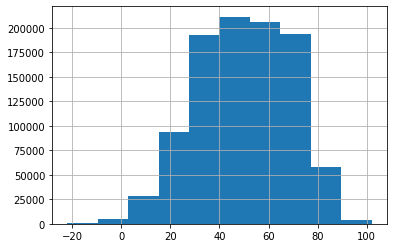

In [11]:
dataset.drybulb.hist()

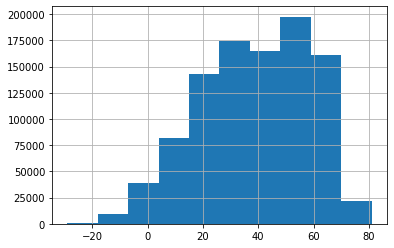

In [12]:
dataset.dewpnt.hist()

In [13]:
import pandas as pd

pivoted = dataset.pivot(index="ts", columns="zone", values="demand")

In [14]:
pivoted.columns

Index(['CT', 'ME', 'NEMASSBOST', 'NH', 'RI', 'SEMASS', 'VT', 'WCMASS'], dtype='object', name='zone')

In [15]:
# we could also add exogenous features like this:
pivoted2 = pivoted.merge(dataset[["ts", 'year', 'month',
       'hour', 'day_of_week', 'day_of_year', 'weekend', 'holiday_name',
       'holiday']], on=["ts"], how="left").drop_duplicates()

In [16]:
T = len(pivoted.index)
split_t = pivoted.index[T//10 * 8]
split_index = pivoted.index < split_t

In [17]:
train, test = pivoted[split_index], pivoted[~split_index]

In [18]:
train.head()

zone,CT,ME,NEMASSBOST,NH,RI,SEMASS,VT,WCMASS
ts,,,,,,,,
2003-03-01 00:00:00,3386.0,1111.0,2574.0,1055.0,791.0,1484.0,608.0,1855.0
2003-03-01 01:00:00,3258.0,1063.0,2477.0,1017.0,760.0,1432.0,587.0,1795.0
2003-03-01 02:00:00,3189.0,1053.0,2426.0,1000.0,741.0,1407.0,578.0,1761.0
2003-03-01 03:00:00,3157.0,1050.0,2420.0,997.0,737.0,1401.0,570.0,1740.0
2003-03-01 04:00:00,3166.0,1077.0,2426.0,1010.0,740.0,1419.0,574.0,1750.0


In [19]:
len(test) / (len(train) + len(test))

0.20000644272817325

# **Modeling**

In [20]:
!pip install skits

In [21]:
# we can use lagmat to transform a time series into a lagged wide dataset:
import numpy as np
from statsmodels.tsa.tsatools import lagmat

X = np.arange(1,7).reshape(-1,2)
# or: X = np.arange(2,7)
lagmat(X, maxlag=2, trim="forward", original='in')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


array([[1., 2., 0., 0., 0., 0.],
       [3., 4., 1., 2., 0., 0.],
       [5., 6., 3., 4., 1., 2.]])

In [22]:
# alternatively, we can use a scikit-learn pipeline with skits
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
# from skits.preprocessing import DifferenceTransformer

from skits.pipeline import ForecasterPipeline
from skits.preprocessing import ReversibleImputer
from skits.feature_extraction import (AutoregressiveTransformer, 
                                      SeasonalTransformer)
#dt = DifferenceTransformer(period=4)
#Xt = dt.fit_transform(
#    train[['CT', 'ME', 'NEMASSBOST', 'NH', 'RI', 'SEMASS', 'VT', 'WCMASS']]
#)


pipeline = ForecasterPipeline([
    ("standard", StandardScaler()),                                                              
    ('features', FeatureUnion([
        ('ar_features', AutoregressiveTransformer(num_lags=3)),
    ])),
    ('post_feature_imputer', ReversibleImputer()),
    ('regressor', LinearRegression(fit_intercept=False))
])

pipeline.fit(train.values, train.values)
y_pred = pipeline.predict(test.values, to_scale=True, refit=True)

In [23]:
from sklearn.metrics import mean_squared_error

mean_squared_error([y_pred[0, 0]], [test.values[0, 0]], squared=False)

3831.0479578492736

In [24]:
mean_squared_error(y_pred, test.values, squared=False)

1867.1884583374926

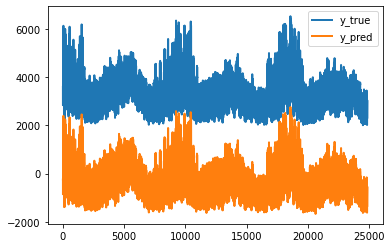

In [25]:
import matplotlib.pyplot as plt

plt.plot(test.values[:, 0], lw=2)
plt.plot(y_pred[:, 0], lw=2)
plt.legend(['y_true', 'y_pred'], bbox_to_anchor=(1, 1));

In [26]:
# from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

pipeline = ForecasterPipeline([
    ('features', FeatureUnion([
        ('ar_features', AutoregressiveTransformer(num_lags=3)),
    ])),
    ('post_feature_imputer', ReversibleImputer()),
    ('regressor', DecisionTreeRegressor())
])

pipeline.fit(train.values, train.values)
y_pred = pipeline.predict(test.values, to_scale=True, refit=True)

In [27]:
mean_squared_error(y_pred, test.values, squared=False)

113.91429875630325

In [28]:
mean_squared_error([y_pred[0, 0]], [test.values[0, 0]], squared=False)

112.0

In [29]:
!pip install xgboost

In [30]:
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor

# other models to try out:
#from sklearn.ensemble import GradientBoostingRegressor
#from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
#from sklearn.tree import DecisionTreeRegressor

pipeline = ForecasterPipeline([
    ('features', FeatureUnion([
        ('ar_features', AutoregressiveTransformer(num_lags=3)),
    ])),
    ('post_feature_imputer', ReversibleImputer()),
    ('regressor', MultiOutputRegressor(XGBRegressor(random_state=0), n_jobs=-1))
])

pipeline.fit(train.values, train.values)
y_pred = pipeline.predict(test.values, to_scale=True, refit=True)

In [31]:
mean_squared_error(y_pred, test.values, squared=False)

95.63873624551869

In [32]:
mean_squared_error([y_pred[0, 0]], [test.values[0, 0]], squared=False)

142.09912109375

In [33]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 1.2 MB/s 


In [34]:
from catboost import CatBoostRegressor
#from sklearn.impute import SimpleImputer

pipeline = ForecasterPipeline([
    #("impute", SimpleImputer(strategy="constant", fill_value=-9999)),
    ('features', FeatureUnion([
        ('ar_features', AutoregressiveTransformer(num_lags=4)),
    ])),
    ('post_feature_imputer', ReversibleImputer()),
    #('regressor', MultiOutputRegressor(CatBoostRegressor(random_state=0), n_jobs=-1))
    ('regressor', CatBoostRegressor(loss_function="MultiRMSE"))
])
pipeline.fit(train.values, train.values)

0:	learn: 1168.0558758	total: 114ms	remaining: 1m 53s
1:	learn: 1138.8358660	total: 168ms	remaining: 1m 23s
2:	learn: 1110.2304935	total: 221ms	remaining: 1m 13s
3:	learn: 1082.6798984	total: 272ms	remaining: 1m 7s
4:	learn: 1055.8654093	total: 332ms	remaining: 1m 5s
5:	learn: 1029.7912059	total: 385ms	remaining: 1m 3s
6:	learn: 1004.8697132	total: 437ms	remaining: 1m 1s
7:	learn: 980.3655862	total: 487ms	remaining: 1m
8:	learn: 957.1145322	total: 545ms	remaining: 60s
9:	learn: 934.5239054	total: 596ms	remaining: 59s
10:	learn: 912.1731184	total: 649ms	remaining: 58.4s
11:	learn: 890.8849297	total: 703ms	remaining: 57.9s
12:	learn: 870.0645972	total: 765ms	remaining: 58.1s
13:	learn: 850.0607295	total: 823ms	remaining: 58s
14:	learn: 830.5480842	total: 876ms	remaining: 57.5s
15:	learn: 811.7930471	total: 929ms	remaining: 57.1s
16:	learn: 793.4101739	total: 990ms	remaining: 57.3s
17:	learn: 775.9962825	total: 1.04s	remaining: 56.8s
18:	learn: 759.4228347	total: 1.09s	remaining: 56.4s
19

ForecasterPipeline(steps=[('features',
                           FeatureUnion(transformer_list=[('ar_features',
                                                           AutoregressiveTransformer(num_lags=4))])),
                          ('post_feature_imputer', ReversibleImputer()),
                          ('regressor',
                           <catboost.core.CatBoostRegressor object at 0x7f465d432d10>)])

In [35]:
y_pred = pipeline.predict(test.values, to_scale=True, refit=True)
mean_squared_error(y_pred, test.values, squared=False)

88.79657507562676

In [36]:
MAXLAGS = 4

target_columns = ['CT', 'ME', 'NEMASSBOST', 'NH', 'RI', 'SEMASS', 'VT', 'WCMASS']
colnames = target_columns * MAXLAGS
lagged = pd.DataFrame(data=lagmat(pivoted, maxlag=MAXLAGS, trim="forward", original='ex'), columns=colnames, index=pivoted.index).join(train[[]])
lagged.head()

,CT,ME,NEMASSBOST,NH,RI,SEMASS,VT,WCMASS,CT,ME,NEMASSBOST,NH,RI,SEMASS,VT,WCMASS,CT,ME,NEMASSBOST,NH,RI,SEMASS,VT,WCMASS,CT,ME,NEMASSBOST,NH,RI,SEMASS,VT,WCMASS
ts,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003-03-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003-03-01 01:00:00,3386.0,1111.0,2574.0,1055.0,791.0,1484.0,608.0,1855.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003-03-01 02:00:00,3258.0,1063.0,2477.0,1017.0,760.0,1432.0,587.0,1795.0,3386.0,1111.0,2574.0,1055.0,791.0,1484.0,608.0,1855.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003-03-01 03:00:00,3189.0,1053.0,2426.0,1000.0,741.0,1407.0,578.0,1761.0,3258.0,1063.0,2477.0,1017.0,760.0,1432.0,587.0,1795.0,3386.0,1111.0,2574.0,1055.0,791.0,1484.0,608.0,1855.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003-03-01 04:00:00,3157.0,1050.0,2420.0,997.0,737.0,1401.0,570.0,1740.0,3189.0,1053.0,2426.0,1000.0,741.0,1407.0,578.0,1761.0,3258.0,1063.0,2477.0,1017.0,760.0,1432.0,587.0,1795.0,3386.0,1111.0,2574.0,1055.0,791.0,1484.0,608.0,1855.0


In [37]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# from sklearn.neural_network import MLPRegressor

split_index = lagged.index < split_t
training = lagged[split_index].join(pivoted, how="left", lsuffix="_lag")
X, y = training[[c for c in training.columns if c not in target_columns]], training[[c for c in training.columns if c in target_columns]]

pipeline = make_pipeline(StandardScaler(), CatBoostRegressor(loss_function="MultiRMSE"))
pipeline.fit(X, y)
testing = lagged[~split_index].join(pivoted, how="left", lsuffix="_lag")
X, y = testing[[c for c in testing.columns if c not in target_columns]], testing[[c for c in testing.columns if c in target_columns]]
forecast = pipeline.predict(X)
print(f"MSE all data: {mean_squared_error(y.values, forecast, squared=False)}")
print(f"MSE first point: {mean_squared_error([y.values[0, 0]], [forecast[0, 0]], squared=False)}")

0:	learn: 1167.6276143	total: 710ms	remaining: 11m 49s
1:	learn: 1137.7566574	total: 1.3s	remaining: 10m 51s
2:	learn: 1108.8696510	total: 1.92s	remaining: 10m 37s
3:	learn: 1080.7095940	total: 2.55s	remaining: 10m 34s
4:	learn: 1053.6525844	total: 3.15s	remaining: 10m 25s
5:	learn: 1027.3317924	total: 3.76s	remaining: 10m 22s
6:	learn: 1001.8117388	total: 4.38s	remaining: 10m 20s
7:	learn: 977.1431968	total: 4.98s	remaining: 10m 17s
8:	learn: 953.5483974	total: 5.61s	remaining: 10m 18s
9:	learn: 930.3806973	total: 6.19s	remaining: 10m 12s
10:	learn: 907.8368348	total: 6.8s	remaining: 10m 11s
11:	learn: 886.1815588	total: 7.41s	remaining: 10m 10s
12:	learn: 865.1147136	total: 7.99s	remaining: 10m 6s
13:	learn: 844.6734539	total: 8.62s	remaining: 10m 6s
14:	learn: 824.8133956	total: 9.23s	remaining: 10m 6s
15:	learn: 805.8165671	total: 9.9s	remaining: 10m 9s
16:	learn: 786.9838657	total: 10.5s	remaining: 10m 7s
17:	learn: 768.9522987	total: 11.1s	remaining: 10m 4s
18:	learn: 751.7808768

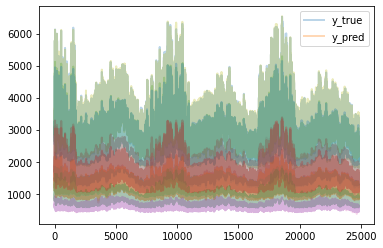

In [38]:
plt.plot(y.values, lw=2, alpha=0.3)
plt.plot(forecast, lw=2, alpha=0.3)
plt.legend(['y_true', 'y_pred'], bbox_to_anchor=(1, 1));